<a href="https://colab.research.google.com/github/aimarydhstr/DFU/blob/main/LossOptiFilterSize150OpAugOPLRGASigmoidRecallFixLiteTransformerFuzzyFUSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Library

In [ ]:
!pip install -U scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 43.9 MB/s eta 0:00:00


## Import Library

In [ ]:
import os
import time
import glob
import shutil
from google.colab import drive
import zipfile

import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.image as tfi
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Activation, SeparableConv2D, Conv2DTranspose, MaxPooling2D, concatenate, Layer, Input, Add, Dropout, BatchNormalization, MultiHeadAttention, LayerNormalization, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import Sequential, initializers
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

from sklearn.metrics import jaccard_score
import skfuzzy as fuzz
import warnings
import logging
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## Fuzzy Sigmoid Layer

In [ ]:
class FuzzyLayer(Layer):
    def __init__(self, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)

    def call(self, inputs):
        b = 0.5  # midpoint
        c = 1.5  # fuzzy scale
        return 1. / (1. + tf.exp(-c * (inputs - b)))

## Fuzzy PostProcessing

In [ ]:
def fuzzy_post_processing(prediction):
    dfu_fuzzy = fuzz.sigmf(prediction, 0.5, 10)
    border_fuzzy = fuzz.gaussmf(prediction, 0.3, 0.1)
    background_fuzzy = fuzz.gaussmf(prediction, 0.1, 0.1)

    combined = dfu_fuzzy * 0.6 + border_fuzzy * 0.3 + background_fuzzy * 0.1

    return combined

## Create Data

In [ ]:
def create_data(data_dir):
    image_paths = []
    mask_paths = []

    folds = sorted(os.listdir(data_dir))
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold.lower() in ['image', 'images']:
            images = sorted(os.listdir(foldpath))
            for image in images:
                if image.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(foldpath, image)
                    image_paths.append(fpath)

        elif fold.lower() in ['mask', 'masks']:
            masks = sorted(os.listdir(foldpath))
            for mask in masks:
                if mask.lower().endswith(('.jpg', '.jpeg', '.png')):
                    fpath = os.path.join(foldpath, mask)
                    mask_paths.append(fpath)
        else:
            continue

    return image_paths, mask_paths

## Load Images

In [ ]:
def load_image(image, grayscale=False):
    if grayscale:
        img = load_img(image, color_mode="grayscale")
    else:
        img = load_img(image)

    return np.round(tfi.resize(img_to_array(img) / 255., (512, 512)), 4)

def load_images(image_paths, mask=False, grayscale=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), 512, 512, 1))
    else:
        images = np.zeros(shape=(len(image_paths), 512, 512, 3))

    for i, image in enumerate(image_paths):
        img = load_image(image, grayscale=grayscale)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img

    return images

## Show Images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

def show_images(imgs, msks):
    plt.figure(figsize=(13,8))

    for i in range(15):
        plt.subplot(3,5,i+1)
        id = np.random.randint(len(imgs))
        show_mask(imgs[id], msks[id], cmap='binary')

    plt.tight_layout()
    plt.show()

## Smoothing Transformer Lite

In [ ]:
class SmoothingTransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(SmoothingTransformerBlock, self).__init__(**kwargs)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim)
        ])
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

## Fuzzy Encoder

In [ ]:
class FuzzyEncoderBlock(Layer):
    def __init__(self, filters, kernel_size=3, rate=0.1, pooling=True, **kwargs):
        super(FuzzyEncoderBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(0.0001))
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(0.0001))
        self.bn2 = BatchNormalization()
        self.pool = MaxPooling2D(pool_size=(2, 2)) if pooling else None
        self.dropout = Dropout(rate)

        self.fuzzy = FuzzyLayer()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = Activation('relu')(x)

        x = self.conv2(x)
        x = Activation('relu')(x)

        if self.pool:
            x = self.pool(x)
            x = self.fuzzy(x)

        return x, inputs

## Decoder

In [ ]:
class DecoderBlock(Layer):
    def __init__(self, filters, rate=0.1, kernel_size=3, kernel_reg=0.0001, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.up = Conv2DTranspose(filters, kernel_size=kernel_size, strides=(2, 2), padding='same')
        self.conv1 = Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(kernel_reg))
        self.bn1 = BatchNormalization()
        self.dropout1 = Dropout(rate)

        self.conv2 = Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(kernel_reg))
        self.bn2 = BatchNormalization()
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        x, skip = inputs
        x = self.up(x)
        x = concatenate([x, skip], axis=3)

        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = Activation('relu')(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = Activation('relu')(x)
        x = self.dropout2(x, training=training)

        return x

## All Metrics

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou

def precision(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_positives = tf.keras.backend.sum(y_true * y_pred)
    predicted_positives = tf.keras.backend.sum(y_pred)

    precision = true_positives / (predicted_positives + smooth)
    return precision

def recall(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_positives = tf.keras.backend.sum(y_true * y_pred)
    actual_positives = tf.keras.backend.sum(y_true)

    recall = true_positives / (actual_positives + smooth)
    return recall

def combined_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce = tf.keras.losses.BinaryCrossentropy()
    bce_loss = bce(y_true, y_pred)

    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)

    combined_loss = 0.5 * dice_loss + 0.5 * bce_loss

    return combined_loss

## Custom Callback

In [ ]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        super(MetricsCallback, self).__init__()
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        y_pred = self.model.predict(self.x_val)
        dice = dice_coefficient(self.y_val, y_pred)
        iou = jaccard_index(self.y_val, y_pred)
        prec = precision(self.y_val, y_pred)
        rec = recall(self.y_val, y_pred)

        print(f'Epoch {epoch + 1} - Dice Coefficient: {dice}, IoU: {iou}, Precision: {prec}, Recall: {rec}')
        logs['val_dice_coefficient'] = float(dice)
        logs['val_jaccard_index'] = float(iou)
        logs['val_precision'] = float(prec)
        logs['val_recall'] = float(rec)

## Mount Google Drive and Extract Dataset

In [ ]:
import os
import zipfile
from sklearn.model_selection import train_test_split
import shutil
from google.colab import drive

drive.mount('/content/drive')
train_zip_path = '/content/drive/My Drive/UNET/NewDataset/augfusc.zip'
test_zip_path = '/content/drive/My Drive/UNET/NewDataset/high_dice_test.zip'

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset/train')
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset/test')

Mounted at /content/drive


## Load and Show Train Dataset

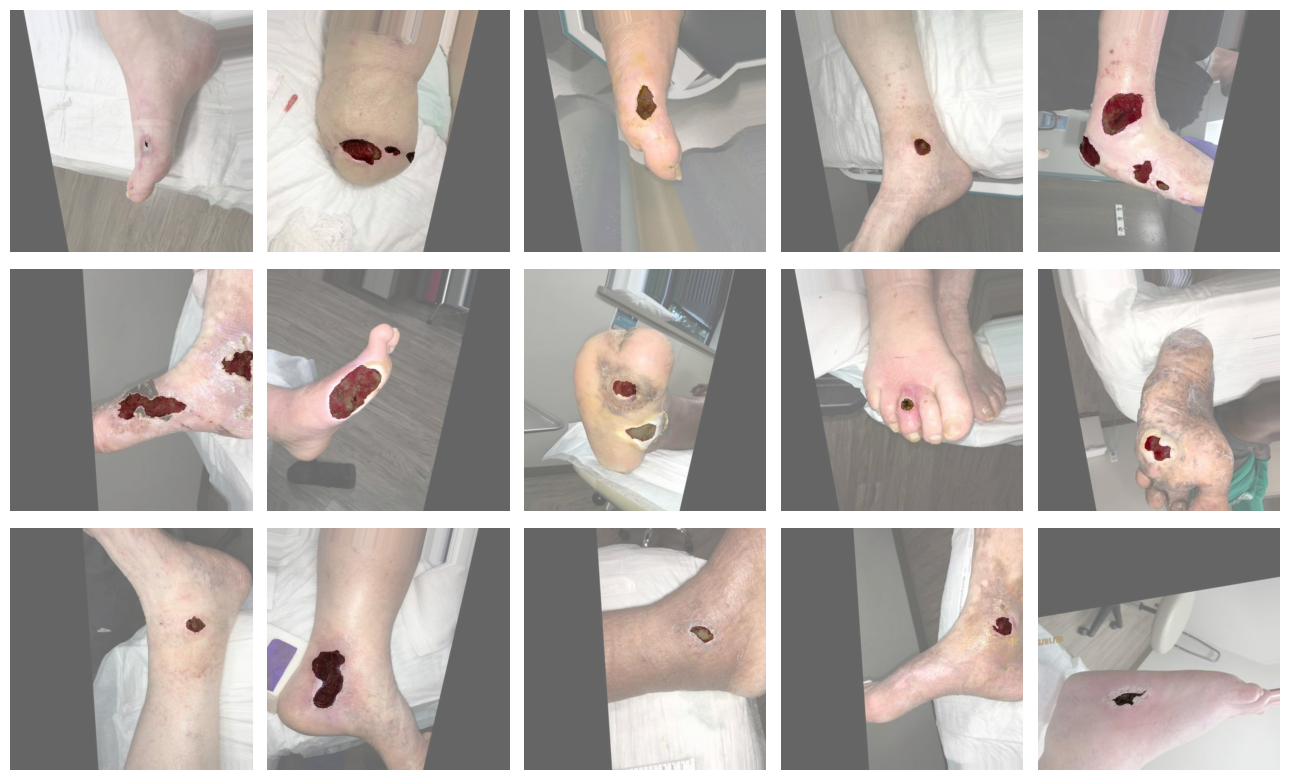

In [ ]:
train_dir = 'dataset/train'
image_paths, mask_paths = create_data(train_dir)

imgs = load_images(image_paths, mask=False, grayscale=False)
msks = load_images(mask_paths, mask=True)

show_images(imgs, msks)

## Create Model

In [ ]:
def create_model(optimizer):
    inputs = Input(shape=(512, 512, 3))
    p1, c1 = FuzzyEncoderBlock(16, pooling=True)(inputs)
    p2, c2 = FuzzyEncoderBlock(32, pooling=True)(p1)
    p3, c3 = FuzzyEncoderBlock(64, pooling=True)(p2)
    p4, c4 = FuzzyEncoderBlock(128, pooling=True)(p3)

    transformer_output = SmoothingTransformerBlock(embed_dim=128, num_heads=4, ff_dim=256)(p4)

    d1 = DecoderBlock(64)([transformer_output, c4])
    d2 = DecoderBlock(32)([d1, c3])
    d3 = DecoderBlock(16)([d2, c2])
    d4 = DecoderBlock(8)([d3, c1])
    output_layer = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(d4)

    model = Model(inputs=[inputs], outputs=[output_layer])
    model.compile(optimizer=optimizer, loss=combined_loss, metrics=[dice_coefficient, jaccard_index, precision, recall])

    return model

optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-4)
model = create_model(optimizer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fuzzy_encoder_block       │ [(None, 256, 256, 16), │          2,832 │ input_layer[0][0]      │
│ (FuzzyEncoderBlock)       │ (None, 512, 512, 3)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fuzzy_encoder_block_1     │ [(None, 128, 128, 32), │         14,016 │ fuzzy_encoder_block[0… │
│ (FuzzyEncoderBlock)       │ (None, 256, 256, 16)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fuzzy_encoder_block_2     │ [(None, 64, 64, 64),   │         55,680 │ fuzzy_encoder_block_1… │
│ (FuzzyEncoderBlock)       │ (None, 128, 128, 32)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fuzzy_encoder_block_3     │ [(None, 32, 32, 128),  │        221,952 │ fuzzy_encoder_block_2… │
│ (FuzzyEncoderBlock)       │ (None, 64, 64, 64)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ smoothing_transformer_bl… │ (None, 32, 32, 128)    │        330,240 │ fuzzy_encoder_block_3… │
│ (SmoothingTransformerBlo… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block             │ (None, 64, 64, 64)     │        185,024 │ smoothing_transformer… │
│ (DecoderBlock)            │                        │                │ fuzzy_encoder_block_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_1           │ (None, 128, 128, 32)   │         46,432 │ decoder_block[0][0],   │
│ (DecoderBlock)            │                        │                │ fuzzy_encoder_block_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_2           │ (None, 256, 256, 16)   │         11,696 │ decoder_block_1[0][0], │
│ (DecoderBlock)            │                        │                │ fuzzy_encoder_block_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_3           │ (None, 512, 512, 8)    │          2,608 │ decoder_block_2[0][0], │
│ (DecoderBlock)            │                        │                │ fuzzy_encoder_block[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 512, 512, 1)    │              9 │ decoder_block_3[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 870,489 (3.32 MB)

 Trainable params: 869,529 (3.32 MB)

 Non-trainable params: 960 (3.75 KB)

## Get Flops

In [ ]:
def get_flops(model):
    input_signature = [tf.TensorSpec([1] + list(model.input_shape[1:]), tf.float32)]
    full_model = tf.function(model).get_concrete_function(input_signature)
    frozen_func = convert_variables_to_constants_v2(full_model)
    run_meta = tf.compat.v1.RunMetadata()

    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph, run_meta=run_meta, options=opts)

    return flops.total_float_ops

tf.get_logger().setLevel(logging.ERROR)
flops = get_flops(model)
print(f"FLOPs: {flops / 10 ** 9:.03} G")

FLOPs: 11.1 G


## Plot Training

In [ ]:
def plot_training(hist):
    tr_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    dice = hist.history['dice_coefficient']
    iou = hist.history['jaccard_index']
    prec = hist.history['precision']
    rec = hist.history['recall']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_dice = np.argmax(dice)
    dice_highest = dice[index_dice]
    index_iou = np.argmax(iou)
    iou_highest = iou[index_iou]
    index_prec = np.argmax(prec)
    prec_highest = prec[index_prec]
    index_rec = np.argmax(rec)
    rec_highest = rec[index_rec]
    Epochs = [i+1 for i in range(len(dice))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    prec_label = f'best epoch= {str(index_prec + 1)}'
    rec_label = f'best epoch= {str(index_rec + 1)}'

    plt.figure(figsize= (20, 18))
    plt.style.use('fivethirtyeight')

    plt.subplot(3, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(Epochs, dice, 'r', label= 'Dice Coefficient')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(Epochs, iou, 'r', label= 'IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Intersection over Union (IoU)')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(Epochs, prec, 'r', label= 'Precision')
    plt.scatter(index_prec + 1 , prec_highest, s= 150, c= 'blue', label= prec_label)
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(Epochs, rec, 'r', label= 'Recall')
    plt.scatter(index_rec + 1 , rec_highest, s= 150, c= 'blue', label= rec_label)
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout
    plt.show()

## Train Configuration

In [ ]:
optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-4)
model = create_model(optimizer)

batch_size = 8
epochs = 150

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
metrics_callback = MetricsCallback(imgs, msks)

## Train Model

In [ ]:
history = model.fit(
    imgs, msks,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[metrics_callback, reduce_lr, early_stopping]
)

Epoch 1/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 277ms/step
Epoch 1 - Dice Coefficient: 0.02877405658364296, IoU: 0.014597036875784397, Precision: 0.014897122979164124, Recall: 0.4201678931713104
230/230 ━━━━━━━━━━━━━━━━━━━━ 246s 695ms/step - dice_coefficient: 0.0342 - jaccard_index: 0.0174 - loss: 0.8891 - precision: 0.0176 - recall: 0.6353 - val_dice_coefficient: 0.0288 - val_jaccard_index: 0.0146 - val_loss: 0.7910 - val_precision: 0.0149 - val_recall: 0.4202 - learning_rate: 1.0000e-04
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
Epoch 2 - Dice Coefficient: 0.03355003520846367, IoU: 0.01706121861934662, Precision: 0.017579277977347374, Recall: 0.3666629493236542
230/230 ━━━━━━━━━━━━━━━━━━━━ 47s 205ms/step - dice_coefficient: 0.0485 - jaccard_index: 0.0249 - loss: 0.7534 - precision: 0.0253 - recall: 0.6892 - val_dice_coefficient: 0.0336 - val_jaccard_index: 0.0171 - val_loss: 0.7080 - val_precision: 0.0176 - val_recall: 0.3667 - learning_rate: 1.0000e-04
Epoch 3/150
72/72 ━━━━━━━━

## Model Save H5 and TFLITE

In [ ]:
model.save('unetLiteFuzzyTransFUSC.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('unetLiteFuzzyTransFUSC.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpes6nmtuc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='keras_tensor_31')
Output Type:
  TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None)
Captures:
  135967972153776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967928077120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967928083456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967928086272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967928085040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967928089440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967928087680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967972152720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967928088208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135967480159168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

## Show Plot Training

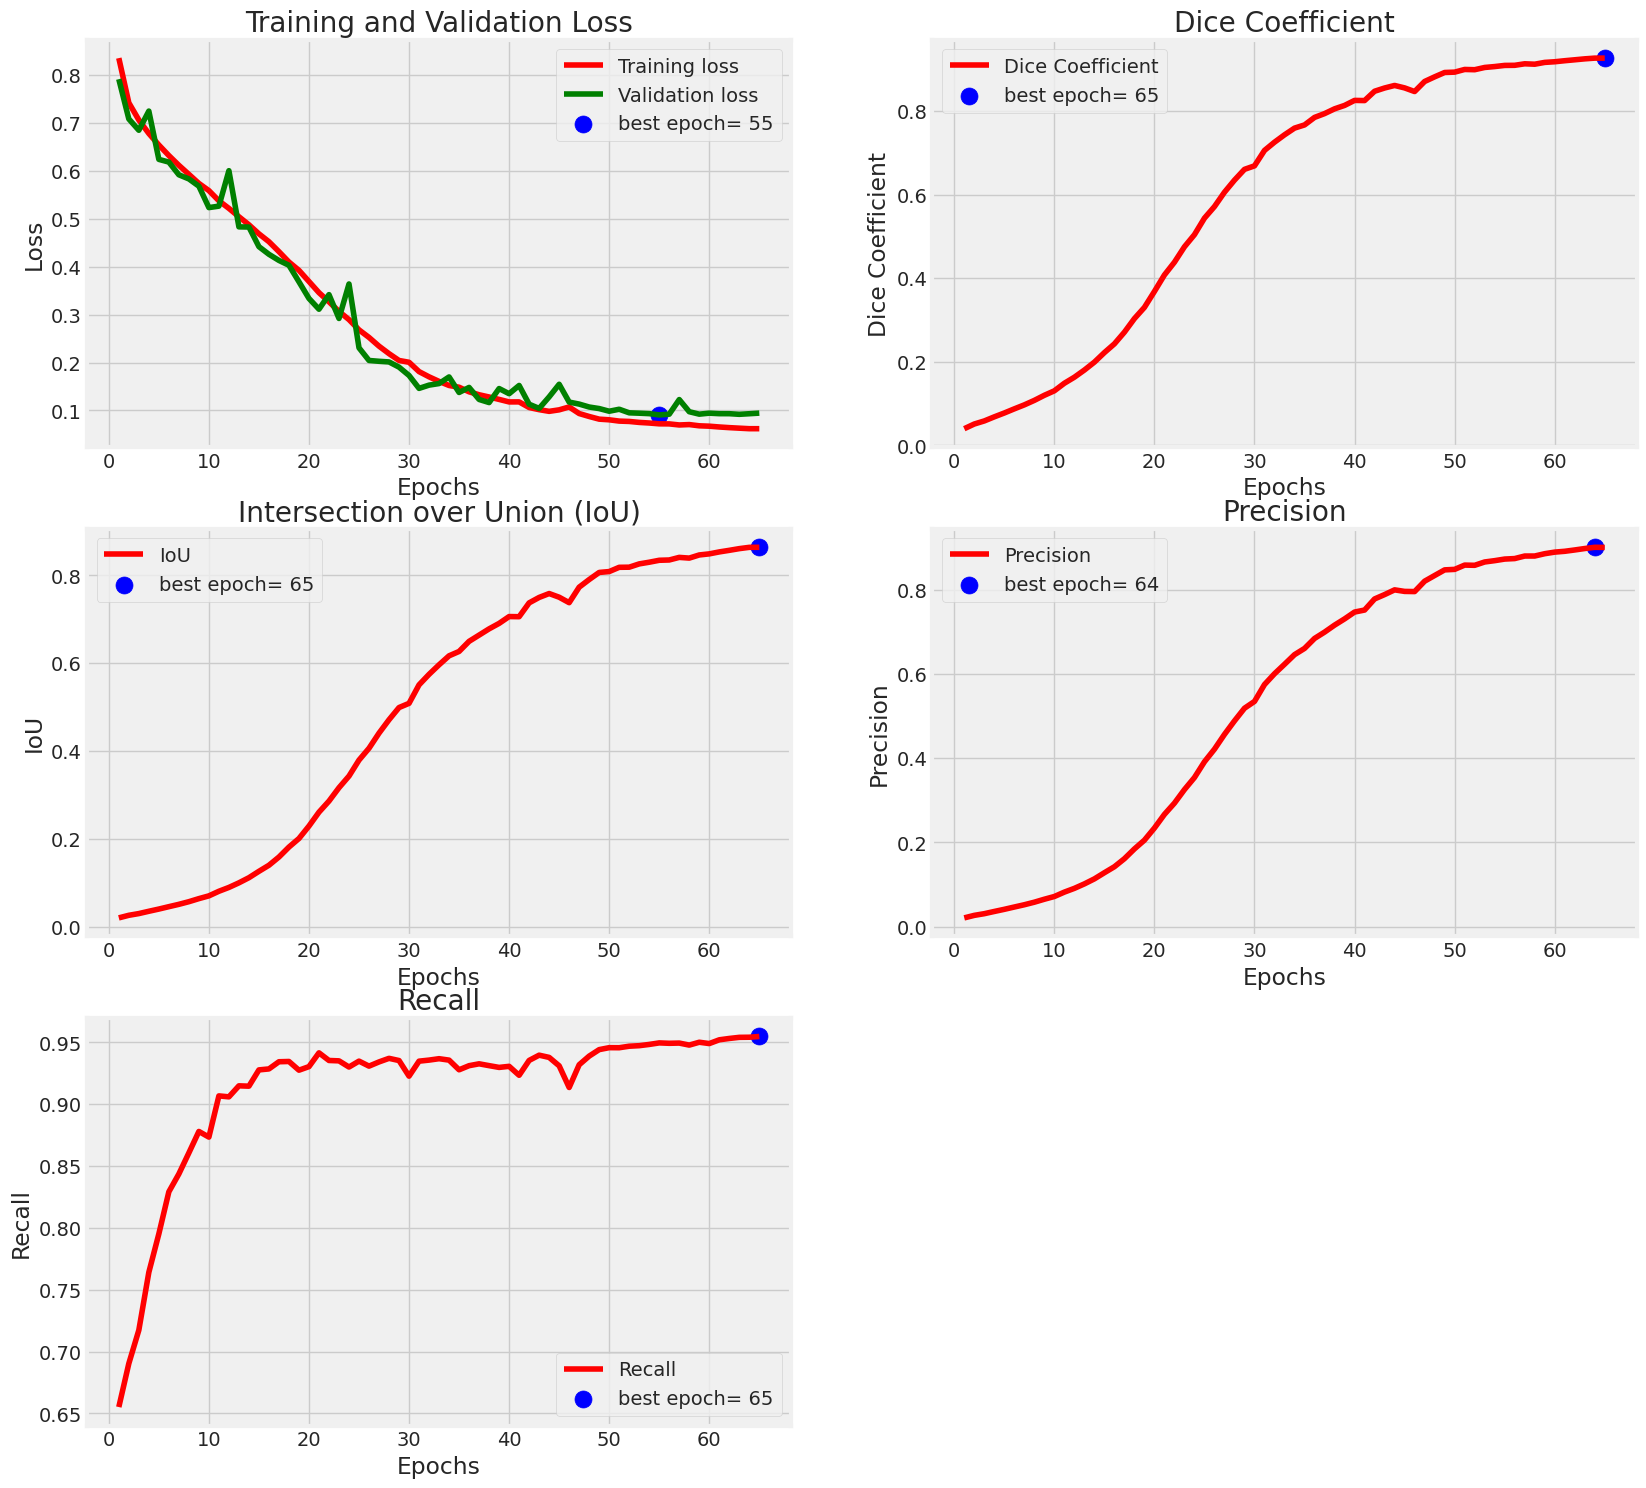

In [ ]:
plot_training(history)

## Model Train Evaluate

In [ ]:
train_metrics = model.evaluate(imgs, msks)
print(f'Training Loss: {train_metrics[0]}')
print(f'Dice Coefficient: {train_metrics[1]}')
print(f'Jaccard Index: {train_metrics[2]}')
print(f'Precision: {train_metrics[3]}')
print(f'Recall: {train_metrics[4]}')

72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - dice_coefficient: 0.9422 - jaccard_index: 0.8912 - loss: 0.0550 - precision: 0.9248 - recall: 0.9606
Training Loss: 0.05937209352850914
Dice Coefficient: 0.9357727766036987
Jaccard Index: 0.8808852434158325
Precision: 0.9216519594192505
Recall: 0.9514732360839844


## Model Train Generalization

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


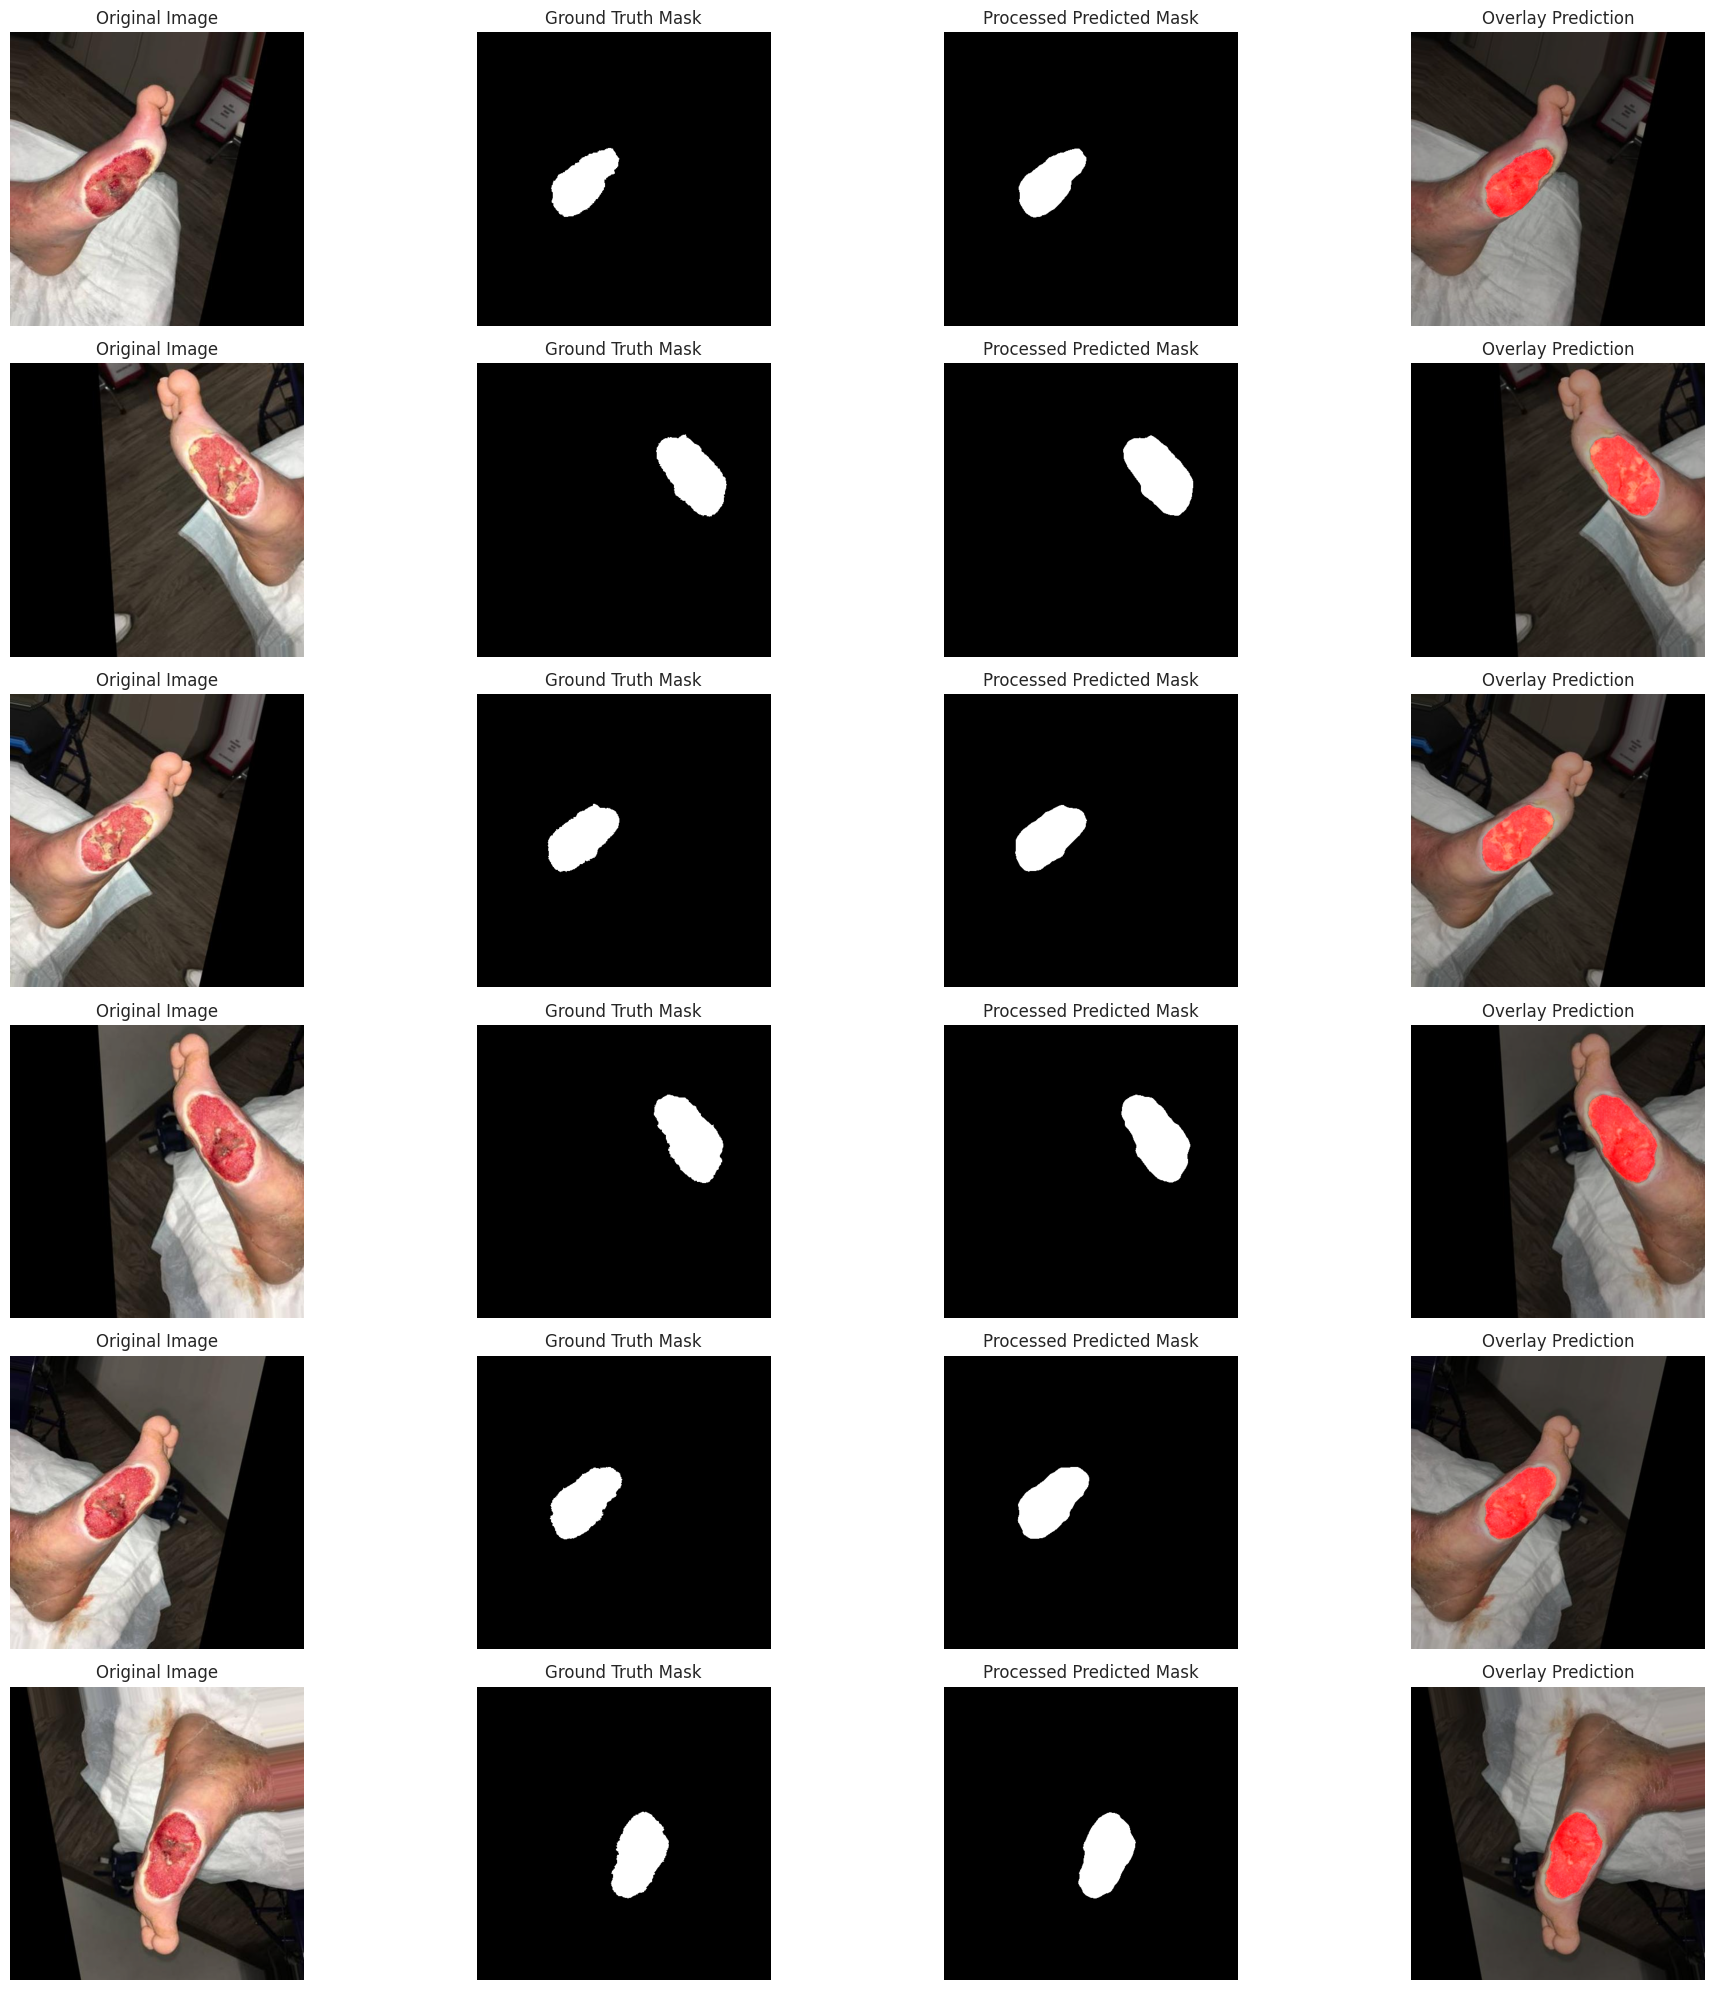

In [ ]:
selected_files = ['0629_aug_1.jpg', '0629_aug_0.jpg', '0536_aug_0.jpg', '0520_aug_1.jpg', '0536_aug_1.jpg', '0629_aug_2.jpg']
selected_indices = [i for i, path in enumerate(image_paths) if path.split('/')[-1] in selected_files]

def calculate_metrics(pred, true):
    pred = pred.flatten()
    true = true.flatten()
    intersection = np.sum(pred * true)
    dice = (2. * intersection) / (np.sum(pred) + np.sum(true) + 1e-6)
    iou = jaccard_score(true, pred, average='binary')
    recall = np.sum(pred * true) / (np.sum(true) + 1e-6)
    precision = np.sum(pred * true) / (np.sum(pred) + 1e-6)
    return dice, iou, recall, precision

preds = model.predict(imgs)
threshold = 0.5
preds_binary = (preds > threshold).astype(np.float32)

def show_selected_predictions(imgs, msks, preds_binary, selected_indices):
    plt.figure(figsize=(20, 20))
    num_samples = len(selected_indices)

    for i, idx in enumerate(selected_indices):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(imgs[idx])
        plt.title(f"Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(np.squeeze(msks[idx]), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        fuzzy_pred_mask = fuzzy_post_processing(preds_binary[idx])
        fuzzy_pred_mask = (fuzzy_pred_mask > 0.5).astype('float')
        kernel = np.ones((5, 5), np.uint8)
        pred_processed = cv2.morphologyEx(fuzzy_pred_mask, cv2.MORPH_CLOSE, kernel)
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(np.squeeze(pred_processed), cmap='gray')
        plt.title("Processed Predicted Mask")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 4)
        overlay = imgs[idx].copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 0] = pred_processed * 255
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)
        plt.imshow(blended)
        plt.title("Overlay Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_selected_predictions(imgs, msks, preds_binary, selected_indices)

## Load Test Dataset

In [ ]:
test_dir = 'dataset/test'
test_image_paths, test_mask_paths = create_data(test_dir)

test_images = load_images(test_image_paths, mask=False, grayscale=False)
test_masks = load_images(test_mask_paths, mask=True)

## Model Test Evaluate

In [ ]:
test_metrics = model.evaluate(test_images, test_masks)
print(f'Test Loss: {test_metrics[0]}')
print(f'Dice Coefficient: {test_metrics[1]}')
print(f'Jaccard Index: {test_metrics[2]}')
print(f'Precision: {test_metrics[3]}')
print(f'Recall: {test_metrics[4]}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - dice_coefficient: 0.9208 - jaccard_index: 0.8534 - loss: 0.0696 - precision: 0.8980 - recall: 0.9461
Test Loss: 0.06839892268180847
Dice Coefficient: 0.9262019991874695
Jaccard Index: 0.8627305030822754
Precision: 0.9135059118270874
Recall: 0.9402257800102234


## Model Test Generalization

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


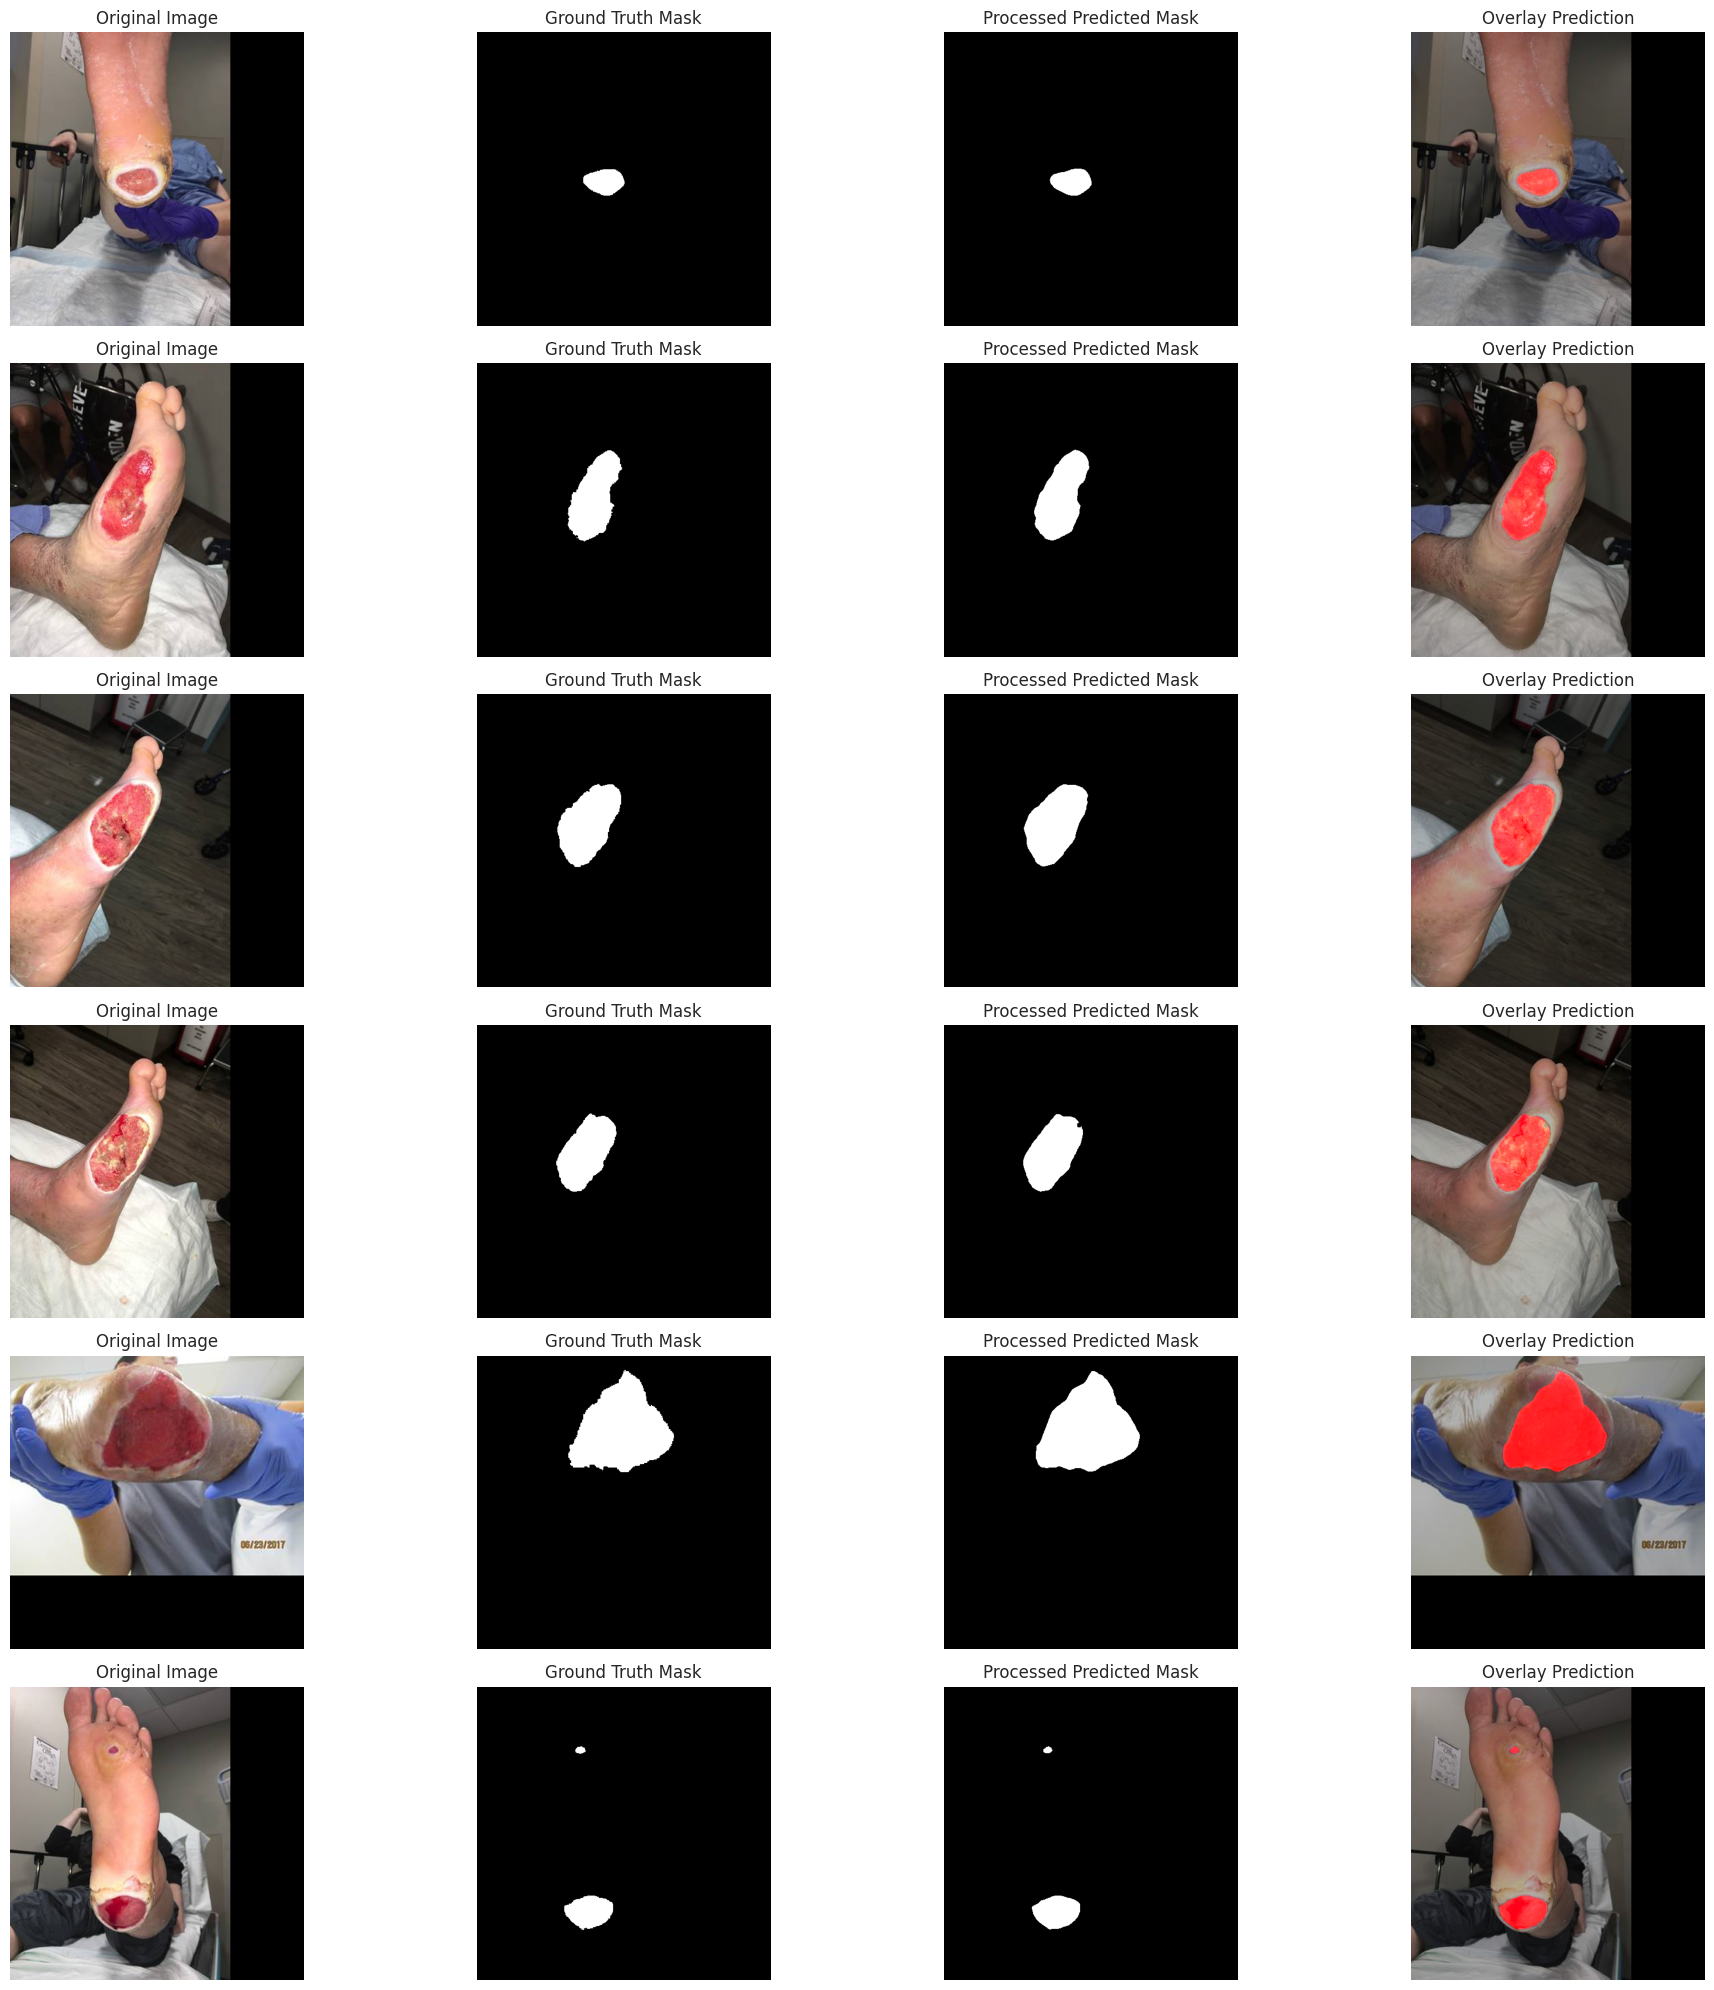

In [ ]:
selected_files = ["0658.png", "0947.png", "0745.png", "1006.png", "0279.png", "0072.png"]
selected_indices = [i for i, path in enumerate(test_image_paths) if path.split('/')[-1] in selected_files]

preds = model.predict(test_images)
preds_binary = (preds > threshold).astype(np.float32)

def show_selected_predictions(test_images, test_masks, preds_binary, selected_indices):
    plt.figure(figsize=(20, 20))
    num_samples = len(selected_indices)

    for i, idx in enumerate(selected_indices):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(test_images[idx])
        plt.title(f"Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(np.squeeze(test_masks[idx]), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        fuzzy_pred_mask = fuzzy_post_processing(preds_binary[idx])
        fuzzy_pred_mask = (fuzzy_pred_mask > 0.5).astype('float')
        kernel = np.ones((5, 5), np.uint8)
        pred_processed = cv2.morphologyEx(fuzzy_pred_mask, cv2.MORPH_CLOSE, kernel)
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(np.squeeze(pred_processed), cmap='gray')
        plt.title("Processed Predicted Mask")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 4)
        overlay = test_images[idx].copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 0] = pred_processed * 255
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)
        plt.imshow(blended)
        plt.title("Overlay Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_selected_predictions(test_images, test_masks, preds_binary, selected_indices)

## Load No Filter Test Dataset

In [ ]:
nofil_test_zip_path = '/content/drive/My Drive/UNET/Dataset/fusctest.zip'

with zipfile.ZipFile(nofil_test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset/nofil_test')

nofil_test_dir = 'dataset/nofil_test'
nofil_test_image_paths, nofil_test_mask_paths = create_data(nofil_test_dir)

nofil_test_images = load_images(nofil_test_image_paths, mask=False, grayscale=False)
nofil_test_masks = load_images(nofil_test_mask_paths, mask=True)

## Model No Filter Test Evaluate

In [ ]:
nofil_test_metrics = model.evaluate(nofil_test_images, nofil_test_masks)
print(f'Test Loss: {nofil_test_metrics[0]}')
print(f'Dice Coefficient: {nofil_test_metrics[1]}')
print(f'Jaccard Index: {nofil_test_metrics[2]}')
print(f'Precision: {nofil_test_metrics[3]}')
print(f'Recall: {nofil_test_metrics[4]}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - dice_coefficient: 0.8658 - jaccard_index: 0.7639 - loss: 0.1010 - precision: 0.8790 - recall: 0.8540
Test Loss: 0.09681989252567291
Dice Coefficient: 0.8740462064743042
Jaccard Index: 0.7767197489738464
Precision: 0.89222651720047
Recall: 0.8576540946960449


## Model No Filter Test Generalization

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


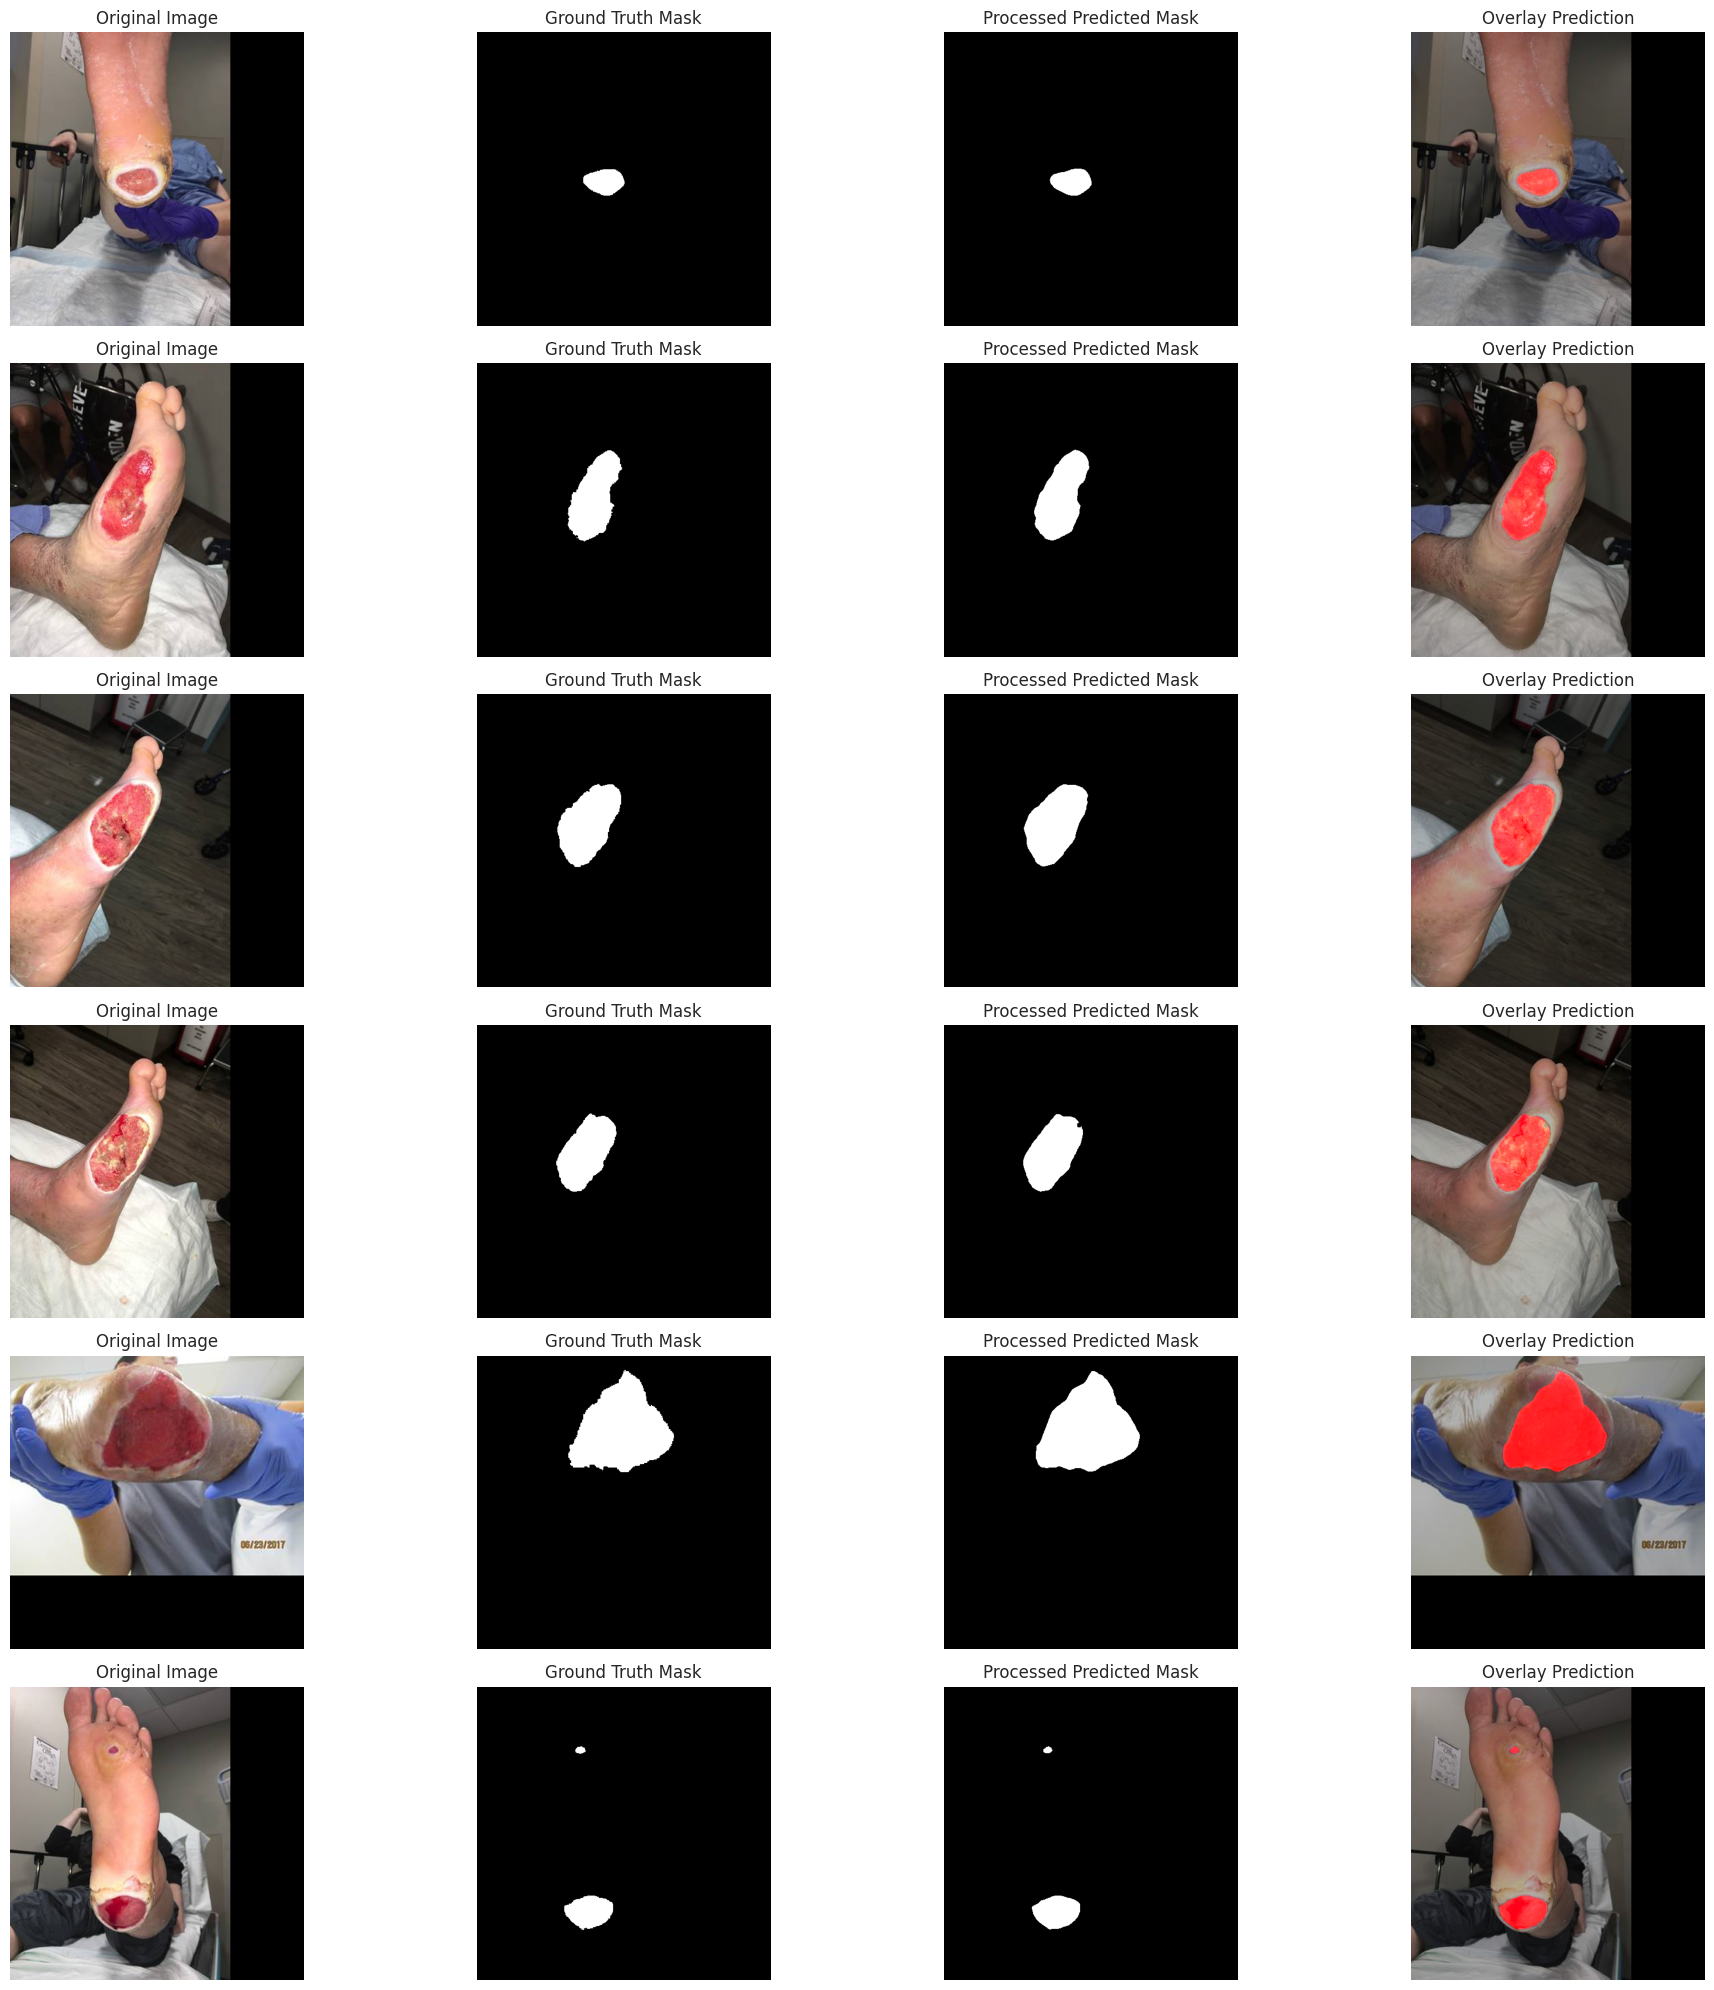

In [ ]:
selected_files = ["0658.png", "0947.png", "0745.png", "1006.png", "0279.png", "0072.png"]
selected_indices = [i for i, path in enumerate(nofil_test_image_paths) if path.split('/')[-1] in selected_files]

preds = model.predict(nofil_test_images)
preds_binary = (preds > threshold).astype(np.float32)

def show_selected_predictions(nofil_test_images, nofil_test_masks, preds_binary, selected_indices):
    plt.figure(figsize=(20, 20))
    num_samples = len(selected_indices)

    for i, idx in enumerate(selected_indices):
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(nofil_test_images[idx])
        plt.title(f"Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(np.squeeze(nofil_test_masks[idx]), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        fuzzy_pred_mask = fuzzy_post_processing(preds_binary[idx])
        fuzzy_pred_mask = (fuzzy_pred_mask > 0.5).astype('float')
        kernel = np.ones((5, 5), np.uint8)
        pred_processed = cv2.morphologyEx(fuzzy_pred_mask, cv2.MORPH_CLOSE, kernel)
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(np.squeeze(pred_processed), cmap='gray')
        plt.title("Processed Predicted Mask")
        plt.axis('off')

        plt.subplot(num_samples, 4, i * 4 + 4)
        overlay = nofil_test_images[idx].copy()
        mask_overlay = np.zeros_like(overlay)
        mask_overlay[:, :, 0] = pred_processed * 255
        blended = cv2.addWeighted(overlay, 0.7, mask_overlay, 0.3, 0)
        plt.imshow(blended)
        plt.title("Overlay Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_selected_predictions(nofil_test_images, nofil_test_masks, preds_binary, selected_indices)